# Integrantes:
* Juan Sebastian Arce 
* Juan Sebastian Montoya

# Parte 1

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# carga del dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
# normalización de los datos
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [19]:
# reshape de los datos para tener un vector unidimensional de tamaño 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [20]:
# definición de la arquitectura del modelo
original_dim = 784
latent_dim = 10
intermediate_dim = 128

inputs = tf.keras.layers.Input(shape=(original_dim,))
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
h = tf.keras.layers.Dense(64, activation='relu')(h)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(h)


In [21]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim),
                                      mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [22]:
# decodificador
decoder_h = tf.keras.layers.Dense(64, activation='relu')
decoder_h2 = tf.keras.layers.Dense(intermediate_dim, activation='relu')
decoder_out = tf.keras.layers.Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
x_decoded = decoder_out(h_decoded)

In [23]:
# construcción del modelo
vae = tf.keras.models.Model(inputs, x_decoded)

In [24]:
# función de pérdida
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, x_decoded)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + 0.001 * kl_loss)
vae.add_loss(vae_loss)

In [25]:
# entrenamiento del modelo
vae.compile(optimizer='adam')
vae.fit(x_train,epochs=50,batch_size=128,validation_data=(x_test, None))
#vae.summary()

Epoch 1/50
469/469 [==============================] - 5s 6ms/step - loss: 275.3058 - val_loss: 243.6796
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 238.2764 - val_loss: 236.7206
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 233.0894 - val_loss: 232.6832
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 230.1218 - val_loss: 230.4584
Epoch 5/50
469/469 [==============================] - 3s 5ms/step - loss: 228.1612 - val_loss: 228.8640
Epoch 6/50
469/469 [==============================] - 3s 5ms/step - loss: 226.7543 - val_loss: 227.8904
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 225.7119 - val_loss: 226.7092
Epoch 8/50
469/469 [==============================] - 3s 5ms/step - loss: 224.9662 - val_loss: 226.2582
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 224.3382 - val_loss: 225.7490
Epoch 10/50
469/469 [==============================] - 3s 5ms/st

In [27]:
# generación de nuevas imágenes a partir del modelo entrenado
n = 10  # número de imágenes a generar
decoded_imgs = vae.predict(x_test[:n])

1/1 [==============================] - 0s 29ms/step


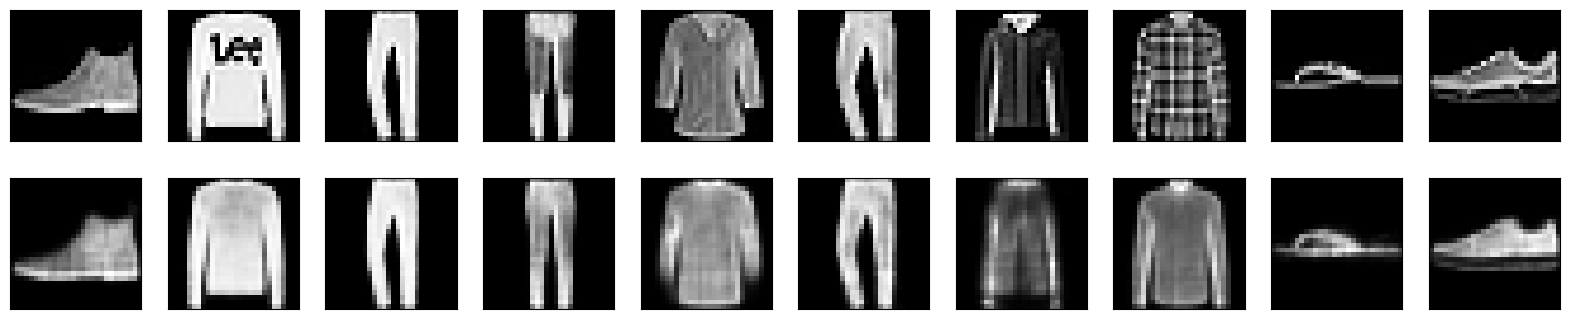

In [28]:
# visualización de las imágenes originales y las reconstruidas
plt.figure(figsize=(20, 4))
for i in range(n):
    # imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# imagen reconstruida
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# PARTE 2

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [30]:
# definición de la arquitectura del modelo
original_dim = 784
latent_dim = 10
intermediate_dim = 128

input_img = tf.keras.layers.Input(shape=(original_dim,))
encoded_co1 = tf.keras.layers.Dense(intermediate_dim, activation='relu')(input_img)
encoded_co2 = tf.keras.layers.Dense(64, activation='relu')(encoded_co1)
z_ae=tf.keras.layers.Dense(latent_dim)(encoded_co2)
decoded_co1 = tf.keras.layers.Dense(64, activation='relu')(z_ae)
decoded_co2 = tf.keras.layers.Dense(intermediate_dim, activation='relu')(decoded_co1)
decoded = tf.keras.layers.Dense(original_dim, activation='sigmoid')(decoded_co2)



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 10)                650       
                                                                 
 dense_13 (Dense)            (None, 64)                704       
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 784)               1011

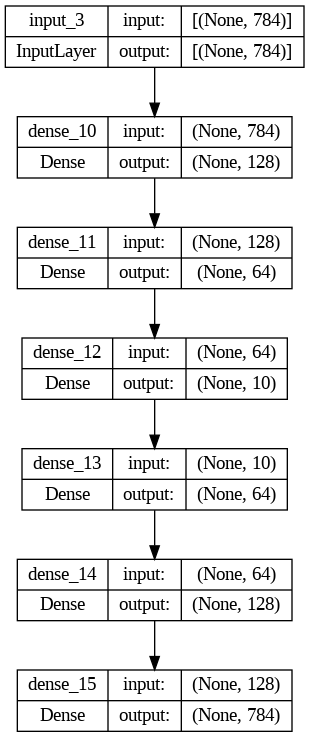

In [31]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()
plot_model(autoencoder, to_file='deepAutoencoder.png', show_shapes=True)

In [32]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 4s 5ms/step - loss: 0.3465 - val_loss: 0.0000e+00
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3029 - val_loss: 0.0000e+00
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2962 - val_loss: 0.0000e+00
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2925 - val_loss: 0.0000e+00
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2904 - val_loss: 0.0000e+00
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2887 - val_loss: 0.0000e+00
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2875 - val_loss: 0.0000e+00
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2865 - val_loss: 0.0000e+00
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2857 - val_loss: 0.0000e+00
Epoch 10/50
469/469 [==============================] - 3s 6ms/st

In [33]:
n = 10  # número de imágenes a generar
decoded_imgs_auto = autoencoder.predict(x_test[:n])

1/1 [==============================] - 0s 74ms/step


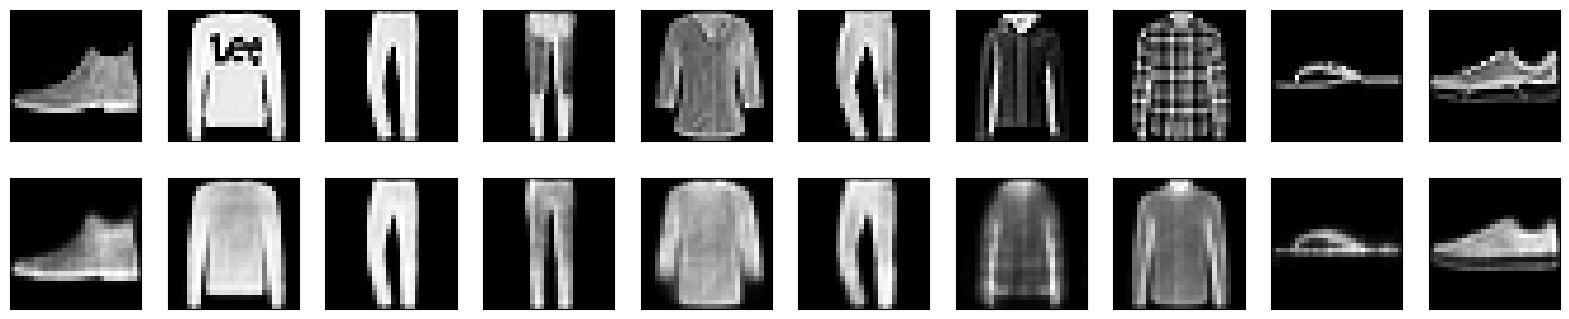

In [34]:
# visualización de las imágenes originales y las reconstruidas
plt.figure(figsize=(20, 4))
for i in range(n):
    # imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# imagen reconstruida
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs_auto[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#Autoencoder loss function
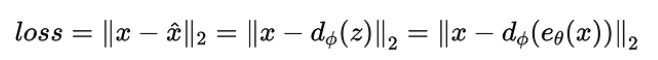

# Variational autoencoder loss function
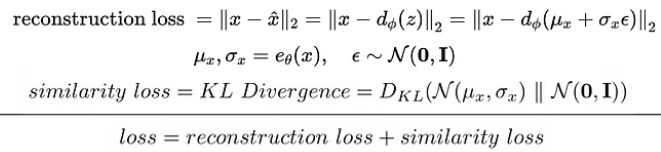

# PREGUNTAS 

## Diferencia entre la función de pérdida del autocodificador variacional y el estandar
El autocodificador variacional utiliza una función de pérdida compuesta de dos términos: uno que mide la diferencia entre la imagen original y la imagen reconstruida, y otro que mide la diferencia entre la distribución de la representación comprimida y una distribución normal estándar mientras que un autocodificador estándar utiliza una función de pérdida que mide la diferencia entre la imagen original y la imagen reconstruida, sin incluir ningún término relacionado con la distribución de la representación comprimida.



## ¿Qué estructura utilizaría para comprimir información?

Si el objetivo es comprimir información, es probable que un autocodificador estándar sea más adecuado que un autocodificador variacional.

En un autocodificador estándar, la capa latente actúa como una representación comprimida de la entrada, lo que significa que se pueden usar menos bits para almacenar la información de la capa latente que la entrada original. Por lo tanto, al reconstruir la entrada a partir de la capa latente, el autocodificador estándar puede comprimir la información.

Por otro lado, un autocodificador variacional no se enfoca en la compresión de la información en sí misma, sino en la generación de muestras a partir de la distribución latente. Aunque el autocodificador variacional también puede ser utilizado para la compresión de información, esto requeriría la codificación de la entrada en una distribución latente y luego la decodificación de la distribución latente para recuperar la entrada original, lo que puede ser menos eficiente que el enfoque directo del autocodificador estándar.

Para finalizar,  si el objetivo es comprimir información, un autocodificador estándar es más adecuado que un autocodificador variacional, ya que la capa latente puede actuar como una representación comprimida de la entrada. Sin embargo, si tu objetivo es generar muestras a partir de una distribución latente, un autocodificador variacional puede ser más adecuado.


## Diferencias con la técnica de PCA
El autodecodificador estándar y el autocodificador variacional son modelos de aprendizaje automático que se utilizan para aprender representaciones latentes de datos de entrada. La técnica PCA (Análisis de Componentes Principales) también es una técnica de aprendizaje automático que se utiliza para encontrar representaciones latentes de los datos de entrada.

La principal diferencia entre un autodecodificador estándar y uno variacional es que el segundo incorpora una distribución de probabilidad en la capa latente, lo que permite muestrear nuevas muestras a partir de ella. Por otro lado, un autodecodificador estándar simplemente aprende una representación latente que es una transformación no lineal de la entrada y se centra en minimizar la distancia entre la entrada y la salida reconstruida.

En cuanto a la técnica PCA, es una técnica de reducción de la dimensionalidad que se utiliza para encontrar una proyección de los datos de entrada en un espacio de menor dimensión mientras se mantiene la mayor cantidad posible de varianza. A diferencia de los autocodificadores, PCA no es un modelo generativo y no aprende una representación latente que pueda ser muestreada para generar nuevas muestras.

Mientras que los autocodificadores aprenden una representación latente de los datos de entrada, el autocodificador variacional permite la generación de nuevas muestras y la técnica PCA se utiliza para la reducción de la dimensionalidad.